In [1]:
import csv
import numpy as np
import pandas as pd
import networkx as nx
import nltk
import re
import matplotlib.pyplot as plt
import emoji
import textacy
import math 
import string

from textacy import preprocessing
from sklearn import preprocessing
from scipy import sparse
from scipy.sparse import csr_matrix, hstack
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight 
from googletrans import Translator
from wordcloud import WordCloud 

#Exclude stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load & Review Data

In [2]:
# Load the textual content of the messages into the dictionary "posts"
posts = dict()
posted_by = dict()
posts_per_class = dict()
with open('data/posts.tsv', 'r', encoding ='utf-8') as f:
    for line in f:
        t = line.split('\t')
        posts[int(t[0])] = t[2][:-1]
        posted_by[int(t[0])] = int(t[1])
        posts_per_class[int(t[1])] = np.zeros(15)

In [3]:
users = dict()
posts_per_user = dict()
with open('data/users.csv', 'r', encoding ='utf-8') as f:
    for line in f.readlines()[1:]:
        t = line.split(',')
        users[int(t[0])] = t[0]
        posts_per_user[int(t[0])] = int(t[3][:-1])

In [4]:
y_data = dict()    
with open('data/train.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        y_data[int(t[0])] = int(t[1])
        posts_per_class[posted_by[int(t[0])]][int(t[1][:-1])] += 1

In [5]:
train_index = list(y_data.keys())
y_train_input =list(y_data.values())

In [6]:
# Read test data
test_index = list()  
with open('data/test.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        test_index.append(int(t[0]))

Text(0, 0.5, 'Number of Tweets')

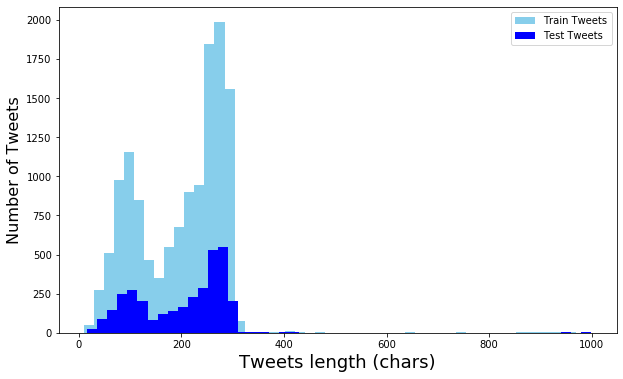

In [7]:
length_train = [len(posts[idx]) for idx in train_index]
length_test = [len(posts[idx]) for idx in test_index]
plt.figure(figsize=(10,6))
plt.hist(length_train,bins=50,label='Train Tweets', color = 'skyblue')
plt.hist(length_test,bins=50,label='Test Tweets', color = 'blue')
plt.legend()
plt.xlabel('Tweets length (chars)', fontsize=18)
plt.ylabel('Number of Tweets', fontsize=16)

In [8]:
def plot_wordCloud(words):
    wordcloud = WordCloud(width=800,height=500,background_color='skyblue',random_state=21,max_font_size=110).generate(words)
    
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

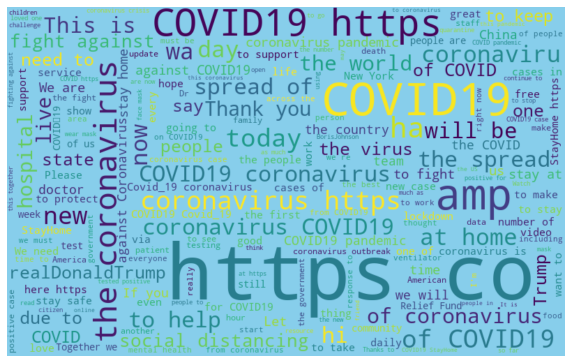

In [9]:
words_posts = ''.join([text for text in posts.values()])
plot_wordCloud(words_posts)

## Text pre-processing

In [10]:
import re
import string
stemmer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 
w_tokenizer = TweetTokenizer()
def clean_str(tweet):
    #emojis to text
    tweet = emoji.demojize(tweet)
    # Removing http
    tweet = re.sub(r"http\S+", "", tweet) 
    # #remove hashtag, @user, link of a tweet using regular expression
    tweet = re.sub("(@[A-Za-z0-9_]+)",'',tweet) 
    # Remove html tags;
    tweet = re.sub(r'&gt;|&lt;|&amp;', '', tweet)  
    # Substituting multiple spaces with single space
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    # Remove puncuation
    tweet = re.sub('[!,$*ー=+_:%‘^“”\)\][(\\-\.\'\'\’\/\|\"\?]', ' ', tweet)
    # Replace #
    tweet = re.sub('#', '', tweet)     
    # Replace numbers
    tweet = re.sub(r'\d+', '', tweet)
    # Remove all single characters
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    

    
    tweet = tweet.lower()
    tweet = w_tokenizer.tokenize((tweet))
    tweet = [stemmer.lemmatize(word) for word in tweet if not word in stop_words]
    # Remove all single characters

    
    tweet = ' '.join(tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    return tweet

twitter_posts = dict()
twitter_posts_zero_len =dict()
for post_idx in posts:
    twitter_posts[post_idx] = clean_str(posts[post_idx])
    if (len (twitter_posts[post_idx]) == 0):
        del y_data[post_idx]
print(posts[0])
print()
print(clean_str(twitter_posts[0]))

Since everyone is on #lockdown because of #COVID19, I want to spread some positivity and surprise some people! 🥰  I am giving five people that retweets this a free #AnimalCrossing Nintendo Switch Bundle, must be following me for a DM! 🎁  Good luck &amp; ! ❤️ #ACNH https://t.co/sIAkfuxZhK

since everyone lockdown covid want spread positivity surprise people smiling face heart giving five people retweets free animalcrossing nintendo switch bundle must following dm wrapped gift good luck red heart acnh


In [11]:
train_index = list(y_data.keys())
y_train_input =list(y_data.values())

In [12]:
# Create 2 lists: one containing the messages of the training set and the other containing the messages of the
# test set
train_posts = [twitter_posts[idx] for idx in train_index]
test_posts = [twitter_posts[idx] for idx in test_index]

In [13]:
train_docs = []
test_docs = []
for idx in train_posts:
    train_docs.append(idx.split())
for idx in test_posts:
    test_docs.append(idx.split())

Text(0, 0.5, 'Number of Tweets')

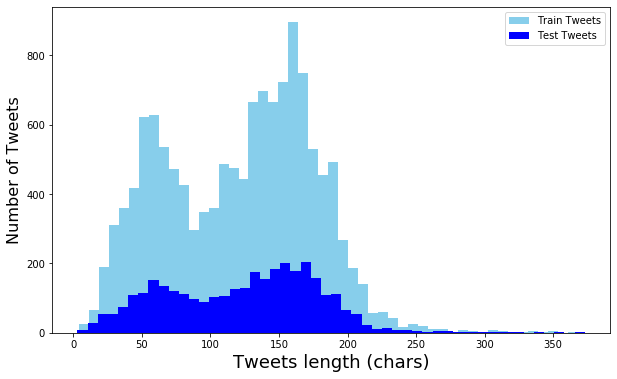

In [14]:
length_train = [len(twitter_posts[idx]) for idx in train_index]
length_test = [len(twitter_posts[idx]) for idx in test_index]
plt.figure(figsize=(10,6))
plt.hist(length_train,bins=50,label='Train Tweets', color = 'skyblue')
plt.hist(length_test,bins=50,label='Test Tweets', color = 'blue')
plt.legend()
plt.xlabel('Tweets length (chars)', fontsize=18)
plt.ylabel('Number of Tweets', fontsize=16)

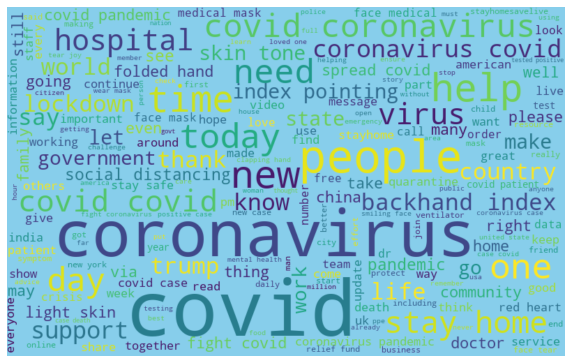

In [15]:
words = ''.join([text for text in twitter_posts.values()])
plot_wordCloud(words)

In [16]:
df = pd.DataFrame(list(zip(train_posts, y_train_input)), columns =['tweets','category']) 

words_category0 = ''.join([text for text in df['tweets'][df['category']==0]])
words_category1 = ''.join([text for text in df['tweets'][df['category']==1]])
words_category2 = ''.join([text for text in df['tweets'][df['category']==2]])
words_category3 = ''.join([text for text in df['tweets'][df['category']==3]])
words_category4 = ''.join([text for text in df['tweets'][df['category']==4]])
words_category5 = ''.join([text for text in df['tweets'][df['category']==5]])
words_category6 = ''.join([text for text in df['tweets'][df['category']==6]])
words_category7 = ''.join([text for text in df['tweets'][df['category']==7]])
words_category8 = ''.join([text for text in df['tweets'][df['category']==8]])
words_category9 = ''.join([text for text in df['tweets'][df['category']==9]])
words_category10 = ''.join([text for text in df['tweets'][df['category']==10]])
words_category11 = ''.join([text for text in df['tweets'][df['category']==11]])
words_category12 = ''.join([text for text in df['tweets'][df['category']==12]])
words_category13 = ''.join([text for text in df['tweets'][df['category']==13]])
words_category14 = ''.join([text for text in df['tweets'][df['category']==14]])

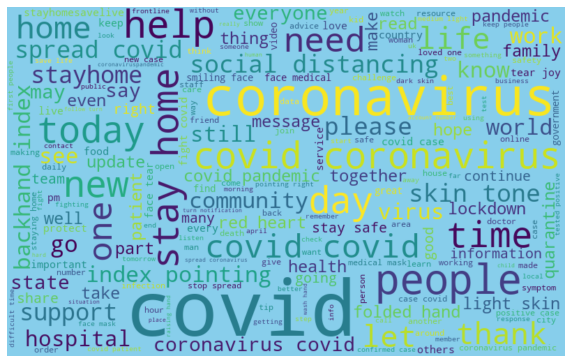

In [17]:
plot_wordCloud(words_category0)

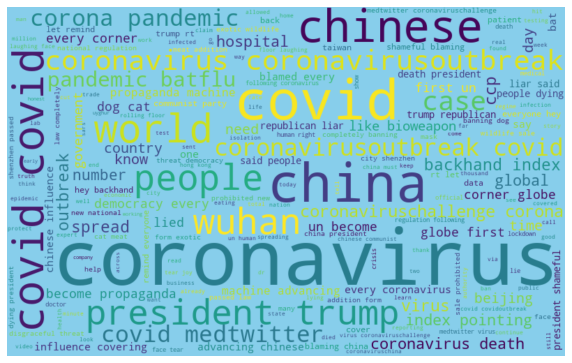

In [18]:
plot_wordCloud(words_category1)

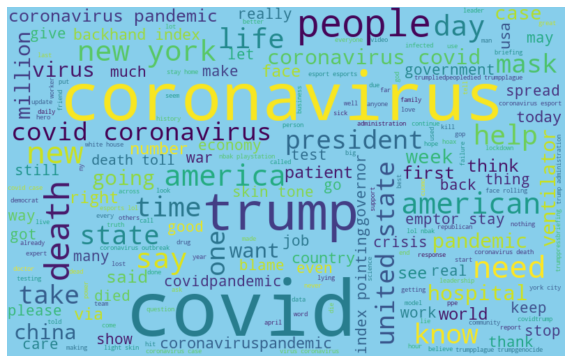

In [19]:
plot_wordCloud(words_category2)

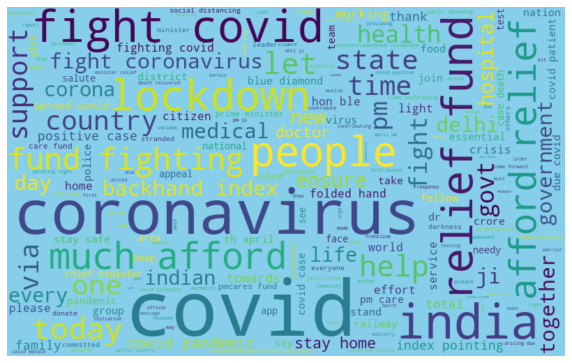

In [20]:
plot_wordCloud(words_category3)

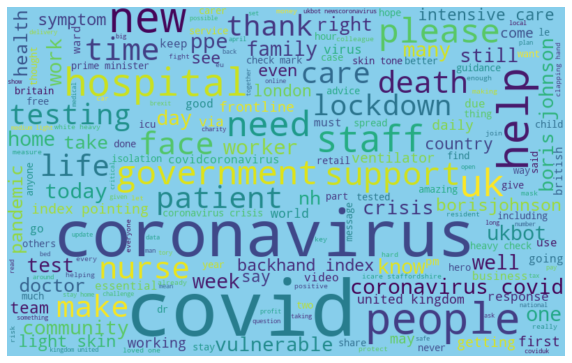

In [21]:
plot_wordCloud(words_category4)

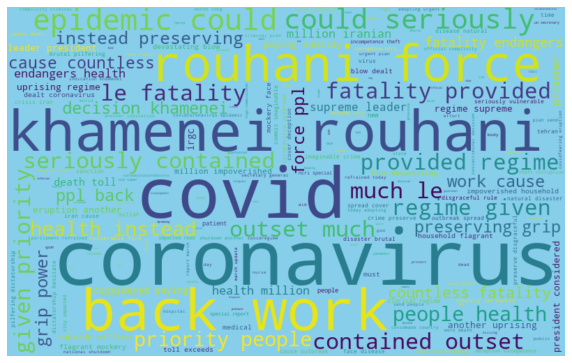

In [22]:
plot_wordCloud(words_category5)

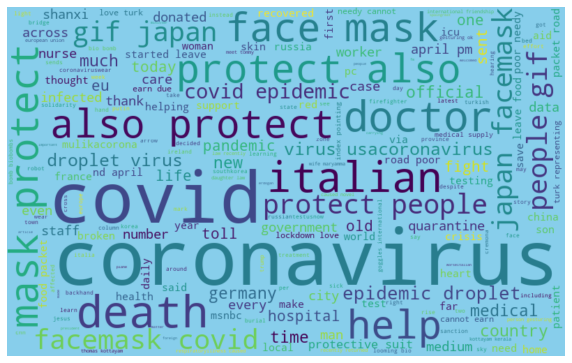

In [23]:
plot_wordCloud(words_category6)

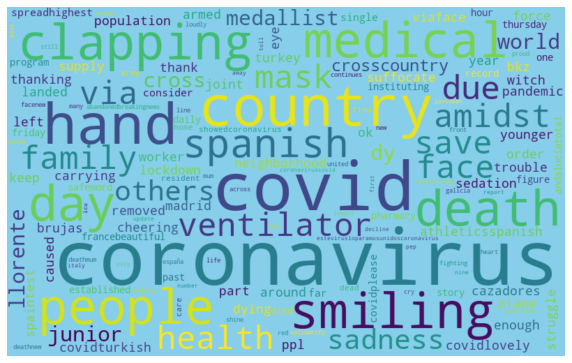

In [24]:
plot_wordCloud(words_category7)

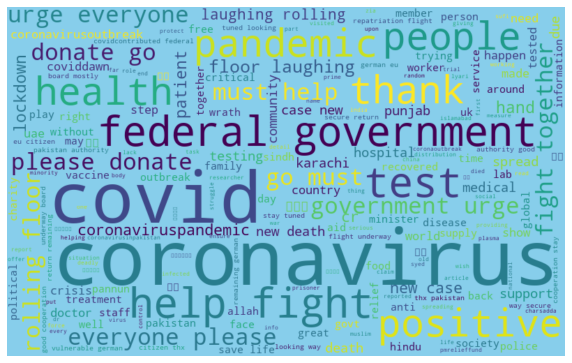

In [25]:
plot_wordCloud(words_category8)

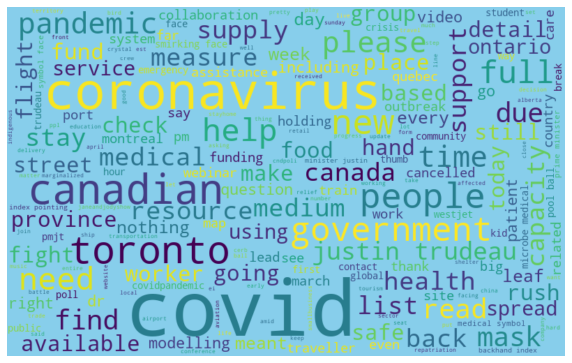

In [26]:
plot_wordCloud(words_category9)

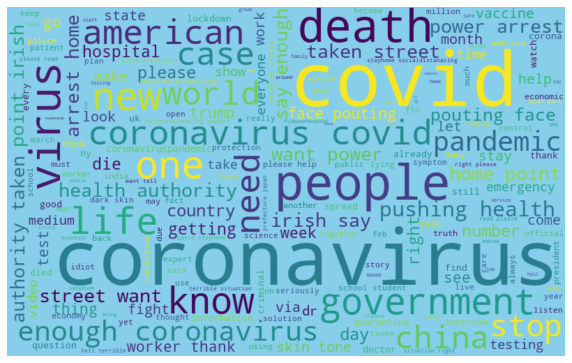

In [27]:
plot_wordCloud(words_category10)

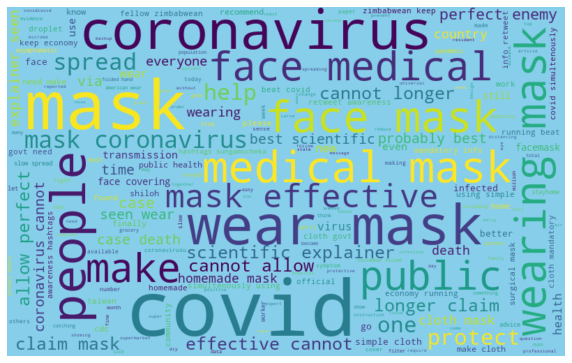

In [28]:
plot_wordCloud(words_category11)

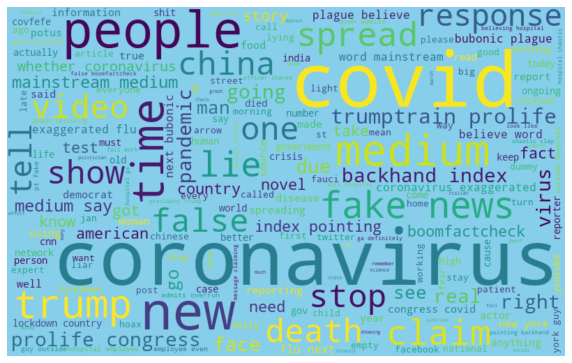

In [29]:
plot_wordCloud(words_category12)

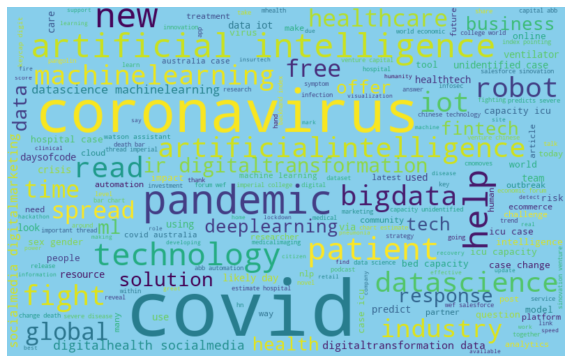

In [30]:
plot_wordCloud(words_category13)

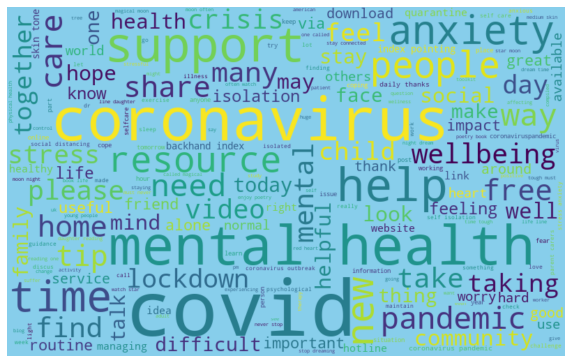

In [31]:
plot_wordCloud(words_category14)

## Twitter posts: TF-IDF

In [32]:
# Create the training matrix. Each row corresponds to a message and each column to a word present in at least 5
# messages of the training set. The value of each entry in a row is equal to the tf-idf weight of that word in the 
# corresponding message 
vectorizer = TfidfVectorizer(ngram_range=(1,3),  max_features = 55000,sublinear_tf=True,min_df = 0.00005,max_df = 0.85, stop_words=stopwords.words('english'))
X_train_input = vectorizer.fit_transform(train_posts)

X_test_final = vectorizer.transform(test_posts)

print("Train matrix dimensionality: ", X_train_input.shape)
print("Test matrix dimensionality: ", X_test_final.shape)

Train matrix dimensionality:  (13220, 55000)
Test matrix dimensionality:  (3306, 55000)


## Graph

In [33]:
import networkx as nx

# Load the processsed retweet network as an undirected graph
G = nx.read_weighted_edgelist("data/retweet_processed_weighted.edgelist", create_using=nx.Graph(), nodetype=int)
nodes = set(G.nodes())
for user in users:
    if user not in nodes:
        G.add_node(user)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 12640
Number of edges: 1356575


In [34]:
from community_louvain import best_partition

partition = best_partition(G)
communities = set(partition.values())
n_communities = len(communities)
print('Number of communities:', n_communities)

Number of communities: 1414


In [35]:
closeness_centrality = dict() 
with open('closeness_centrality.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        closeness_centrality[int(t[0])] = t[1][:-1]
        
page_rank = dict() 
with open('pagerank.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        page_rank[int(t[0])] = t[1][:-1]

In [36]:
# Create the training matrix
X_train_graph = np.zeros((len(train_index), 19))
for i,idx in enumerate(train_index):
    for neighbor in G.neighbors(posted_by[idx]):
        if partition[neighbor] == partition[posted_by[idx]]:
            X_train_graph[i,:15] += posts_per_class[neighbor]

    if np.sum(X_train_graph[i,:15]) > 0:
        X_train_graph[i,:15] /= np.sum(X_train_graph[i,:15])

    X_train_graph[i,15] = G.degree(posted_by[idx])  
    X_train_graph[i,16] = partition[posted_by[idx]] 
    X_train_graph[i,17] = page_rank[posted_by[idx]]
    X_train_graph[i,18] = closeness_centrality[posted_by[idx]]


# Create the test matrix 
X_test_graph = np.zeros((len(test_index), 19))
for i,idx in enumerate(test_index):
    for neighbor in G.neighbors(posted_by[idx]):
        if partition[neighbor] == partition[posted_by[idx]]:
            X_test_graph[i,:15] += posts_per_class[neighbor]

    if np.sum(X_test_graph[i,:15]) > 0:
        X_test_graph[i,:15] /= np.sum(X_test_graph[i,:15])

    X_test_graph[i,15] = G.degree(posted_by[idx])  
    X_test_graph[i,16] = partition[posted_by[idx]] 
    X_test_graph[i,17] = page_rank[posted_by[idx]]
    X_test_graph[i,18] = closeness_centrality[posted_by[idx]]

    
print("Train matrix dimensionality: ", X_train_graph.shape)
print("Test matrix dimensionality: ", X_test_graph.shape)

Train matrix dimensionality:  (13220, 19)
Test matrix dimensionality:  (3306, 19)


In [37]:
X_train_graph_normalized = preprocessing.normalize(X_train_graph)
X_test_graph_normalized = preprocessing.normalize(X_test_graph)

### Deep Walk

In [38]:
from random import randint

def random_walk(G, node, walk_length):
    # Starts from vertex "node" and performs a random walk of length "walk length". Returns a list of the visited vertices
    walk = [node]
    
    for i in range(walk_length-1):
        neighbors = list(G.neighbors(walk[-1]))
        if len(neighbors) > 0:
            next_node = neighbors[randint(0, len(neighbors)-1)]
            walk.append(next_node)
        else:
            break

    walk = [str(node) for node in walk]
    return walk

In [39]:
def generate_walks(graph, num_walks, walk_length):
    # Runs "num_walks" random walks from each node, and returns a list of all random walk
    walks = []
    
    for i in range(num_walks):
        for node in graph.nodes():
            walks.append(random_walk(graph, node, walk_length))

    return walks

In [40]:
walks = generate_walks(G, 10, 15)

In [41]:
from gensim.models import Word2Vec

word2vec_size = 300

model = Word2Vec(size=word2vec_size, window=5, min_count=0, sg=1, workers=8)
model.build_vocab(walks)
model.train(walks, total_examples=model.corpus_count, epochs=10)

c:\users\user\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(17170800, 17170800)

In [42]:
X_train_walks = np.zeros((len(train_index), word2vec_size))
for i,idx in enumerate(train_index):
    X_train_walks[i,:] = model.wv[str(posted_by[idx])]
    

X_test_walks = np.zeros((len(test_index), word2vec_size))
for i,idx in enumerate(test_index):
    X_test_walks[i,:] = model.wv[str(posted_by[idx])]
    
print("Dimensionality of training matrix:", X_train_walks.shape)
print("Dimensionality of test matrix:", X_test_walks.shape)

Dimensionality of training matrix: (13220, 300)
Dimensionality of test matrix: (3306, 300)


In [43]:
X_train_walks_normalized = preprocessing.normalize(X_train_walks)
X_test_walks_normalized = preprocessing.normalize(X_test_walks)

## Text & Users features

In [44]:
user_status = dict()

for id in posts_per_user:
    if posts_per_user[id] < 1000:
        user_status[id] = -1
    elif posts_per_user[id] >= 1000 and posts_per_user[id] < 10000:
        user_status[id] = 0
    else:
        user_status[id] = 1

In [45]:
def count_occurrences(word, sentence):
    return sentence.lower().split().count(word)

In [46]:
textFeatures_size = 6

X_train_textFeatures = np.zeros((len(train_index), textFeatures_size))
for i,idx in enumerate(train_index):
    X_train_textFeatures[i,0] = len(twitter_posts[idx])
    X_train_textFeatures[i,1] = len(twitter_posts[idx].split())
    X_train_textFeatures[i,2] = len(twitter_posts[idx]) / len(twitter_posts[idx].split())
    X_train_textFeatures[i,3] = user_status[posted_by[idx]]
    X_train_textFeatures[i,4] = count_occurrences('hashtag',twitter_posts[idx])
    X_train_textFeatures[i,5] = count_occurrences('number',twitter_posts[idx])
    
X_test_textFeatures = np.zeros((len(test_index), textFeatures_size))
for i,idx in enumerate(test_index):
    X_test_textFeatures[i,0] = len(twitter_posts[idx])
    X_test_textFeatures[i,1] = len(twitter_posts[idx].split())
    X_test_textFeatures[i,2] = len(twitter_posts[idx]) / len(twitter_posts[idx].split())
    X_test_textFeatures[i,3] = user_status[posted_by[idx]]
    X_test_textFeatures[i,4] = count_occurrences('hashtag',twitter_posts[idx])
    X_test_textFeatures[i,5] = count_occurrences('number',twitter_posts[idx])

In [47]:
X_train_textFeatures_normalized = preprocessing.normalize(X_train_textFeatures)
X_test_textFeatures_normalized = preprocessing.normalize(X_test_textFeatures)

## Doc2vec

In [48]:
from gensim.models import doc2vec
from gensim.models import Doc2Vec

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [49]:
X_train_gen = label_sentences(train_posts, 'Train')
X_test_gen = label_sentences(test_posts, 'Test')
all_data = X_train_gen + X_test_gen

In [50]:
from tqdm import tqdm
from sklearn import utils

In [51]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 16526/16526 [00:00<00:00, 2070651.77it/s]


In [52]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████| 16526/16526 [00:00<00:00, 948183.63it/s]


Wall time: 30.9 s


In [53]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [54]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train_gen), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test_gen), 300, 'Test')

In [55]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 16526/16526 [00:00<00:00, 1506325.36it/s]


In [56]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|███████████████████████████████████████████████████████████████████████| 16526/16526 [00:00<00:00, 3314131.86it/s]


Wall time: 1min 8s


In [57]:
train_vectors_dm = get_vectors(model_dm, len(X_train_gen), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test_gen), 300, 'Test')

In [58]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [59]:
def get_concat_vectors(model1,model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
    return vectors

In [60]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_train_gen), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_test_gen), 600, 'Test')

In [61]:
train_vecs_dbow_dm_normalized = preprocessing.normalize(train_vecs_dbow_dm)
test_vecs_dbow_dm_normalized = preprocessing.normalize(test_vecs_dbow_dm)

### Final Datasets

In [62]:
categories = [str(x) for x in np.arange(0, 15, 1)]

In [63]:
X_train_input_final = csr_matrix(hstack([X_train_input,X_train_walks,X_train_textFeatures_normalized,train_vecs_dbow_dm_normalized,X_train_graph_normalized]))
X_kaggle = csr_matrix(hstack([X_test_final,X_test_walks,X_test_textFeatures_normalized,test_vecs_dbow_dm_normalized,X_test_graph_normalized]))


from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X_train_input_final, y_train_input, test_size=0.25, random_state=23828748)

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(solver="liblinear", C=5, max_iter=100)
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)
score = f1_score(y_train,predictions,average='micro')
print("train f1-score: %.2f%%"%(score*100))

predictions_test = clf.predict(X_test)
score = f1_score(y_test, predictions_test,average='micro')
print("test f1-score: %.2f%%"%(score*100))
print()
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
print(pd.crosstab(y_true, y_pred))
print(classification_report(y_true, y_pred,target_names=categories))

train f1-score: 97.20%
test f1-score: 71.89%

test data confusion matrix
Predicted    0   1    2    3    4   5   6   8   9   10  11  12  13  14
True                                                                  
0          1219   7   89   36   40   1   0   0   1   1  11   3   2   4
1            24  90   27    5    4   0   0   0   1   3   1   7   1   0
2           120   7  428    4    8   1   0   0   0  10   2   8   0   0
3            51   2    5  272    3   0   0   1   0   0   0   0   0   1
4            98   2   17    3  128   0   0   0   0   3   1   1   0   3
5             5   0    5    0    0  34   0   0   0   1   0   1   0   0
6            14   1    3    3    4   0   6   0   0   0   0   0   0   0
7             3   0    2    1    0   0   0   0   0   0   0   0   0   1
8            14   2    1    1    1   0   0  11   0   0   0   0   0   0
9            15   1    1    0    0   0   0   0   2   0   1   0   0   0
10           43   7   37    1    3   0   1   0   0  24   3   7   0   0
11  

c:\users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
